In [1]:
import torch
from abc import ABC, abstractmethod
import numpy as np

In [2]:
def calc_out_shape(in_batch_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, in_height, in_width = in_batch_shape
    out_height = (in_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    out_width = (in_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, out_height, out_width

In [3]:
calc_out_shape((1, 12, 512, 512), 3, 9, 1, 4)

(1, 3, 512, 512)

In [4]:
# Абстрактный класс для сверточного слоя
class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, in_batch):
        pass

In [5]:
# Класс-обертка над torch.nn.Conv2d для унификации интерфейса
# С этим классом будем сравниваться
class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=False
        )

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, in_batch):
        return self.conv2d(in_batch)

In [6]:
# функция, создающая объект класса cls и возвращающая свертку от in_batch (входных данных)
# Только для типов данных numpy array и tensor
def create_and_call_conv2d_layer(conv2d_layer_class, stride, padding, kernel, in_batch):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride, padding)
    layer.set_kernel(kernel)

    return layer(in_batch)

In [7]:
# Функция, тестирующая класс conv2d_cls
# Задает ядро и входные данные
# Возвращает True, если свертка совпадает со сверткой с помощью torch.nn.Conv2d
def test_conv2d_layer(conv2d_layer_class, batch_size=2, in_height=3, in_width=3, stride=2, padding=2):
    kernel = torch.tensor([[
        [[0., 1, 0],
         [1,  2, 1],
         [0,  1, 0]],

        [[1, 2, 1],
         [0, 3, 3],
         [0, 1, 10]]
    ]])

    print("KERNEL:", kernel, "KERNEL SHAPE:", kernel.shape, sep = "\n", end="\n\n")
    in_channels = kernel.shape[1]
    in_batch = torch.arange(
        0, batch_size * in_channels * in_height * in_width,
        dtype=torch.float32
    ).reshape(batch_size, in_channels, in_height, in_width)
    print("INPUT BATCH:", in_batch, "INPUT BATCH SHAPE:", in_batch.shape, sep = "\n", end="\n\n")

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, padding, kernel, in_batch
    )
    print("CONV ANSWER:", custom_conv2d_out, "CONV ANSWER SHAPE:", custom_conv2d_out.shape, sep = "\n", end="\n\n")
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, padding, kernel, in_batch
    )
    print("REAL ANSWER:", conv2d_out, "REAL ANSWER SHAPE:", conv2d_out.shape, sep = "\n", end="\n\n")

    return torch.allclose(custom_conv2d_out, conv2d_out) \
             and (custom_conv2d_out.shape == conv2d_out.shape)

In [8]:
# Таже тестовая функция, но для данных, заданных как list 
# Немного читерю, используя и другие типы данных, но для тестирования сойдет
def test_conv2d_layer_for_list(conv2d_layer_class, batch_size=2, in_height=3, in_width=3, stride=2, padding=2):
    kernel = torch.tensor([[
        [[0., 1, 0],
         [1,  2, 1],
         [0,  1, 0]],
        
        [[1, 2, 1],
         [0, 3, 3],
         [0, 1, 10]]
        ]])
    kernel_list = kernel.tolist()
    print("KERNEL:", kernel_list, "KERNEL SHAPE:", kernel.shape, sep = "\n", end="\n\n")

    in_channels = kernel.shape[1]
    out_channels = kernel.shape[0]
    kernel_size = kernel.shape[2]

    in_batch = torch.arange(
        0, batch_size * in_channels * in_height * in_width,
        dtype=torch.float32
    ).reshape(batch_size, in_channels, in_height, in_width)
    in_batch_list = in_batch.tolist()
    print("INPUT BATCH:", in_batch_list, "INPUT BATCH SHAPE:", in_batch.shape, sep = "\n", end="\n\n")

    custom_conv2d_layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride, padding)
    custom_conv2d_layer.set_kernel(kernel_list) # Собсна, вот он
    custom_conv2d_out = custom_conv2d_layer(in_batch_list)
    custom_conv2d_out_np = np.array(custom_conv2d_out, dtype=np.float32)
    print("CONV ANSWER:", custom_conv2d_out, "CONV ANSWER SHAPE:", custom_conv2d_out_np.shape, sep = "\n", end="\n\n")

    base_conv2d_layer = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    base_conv2d_layer.set_kernel(kernel)
    base_conv2d_out = base_conv2d_layer(in_batch)
    print("REAL ANSWER:", base_conv2d_out, "REAL ANSWER SHAPE:", base_conv2d_out.shape, sep = "\n", end="\n\n")

    # Сравнивает только тензорные типы
    return torch.allclose(torch.tensor(custom_conv2d_out_np), base_conv2d_out) \
             and (custom_conv2d_out_np.shape == base_conv2d_out.shape)

# Сверточный слой через циклы

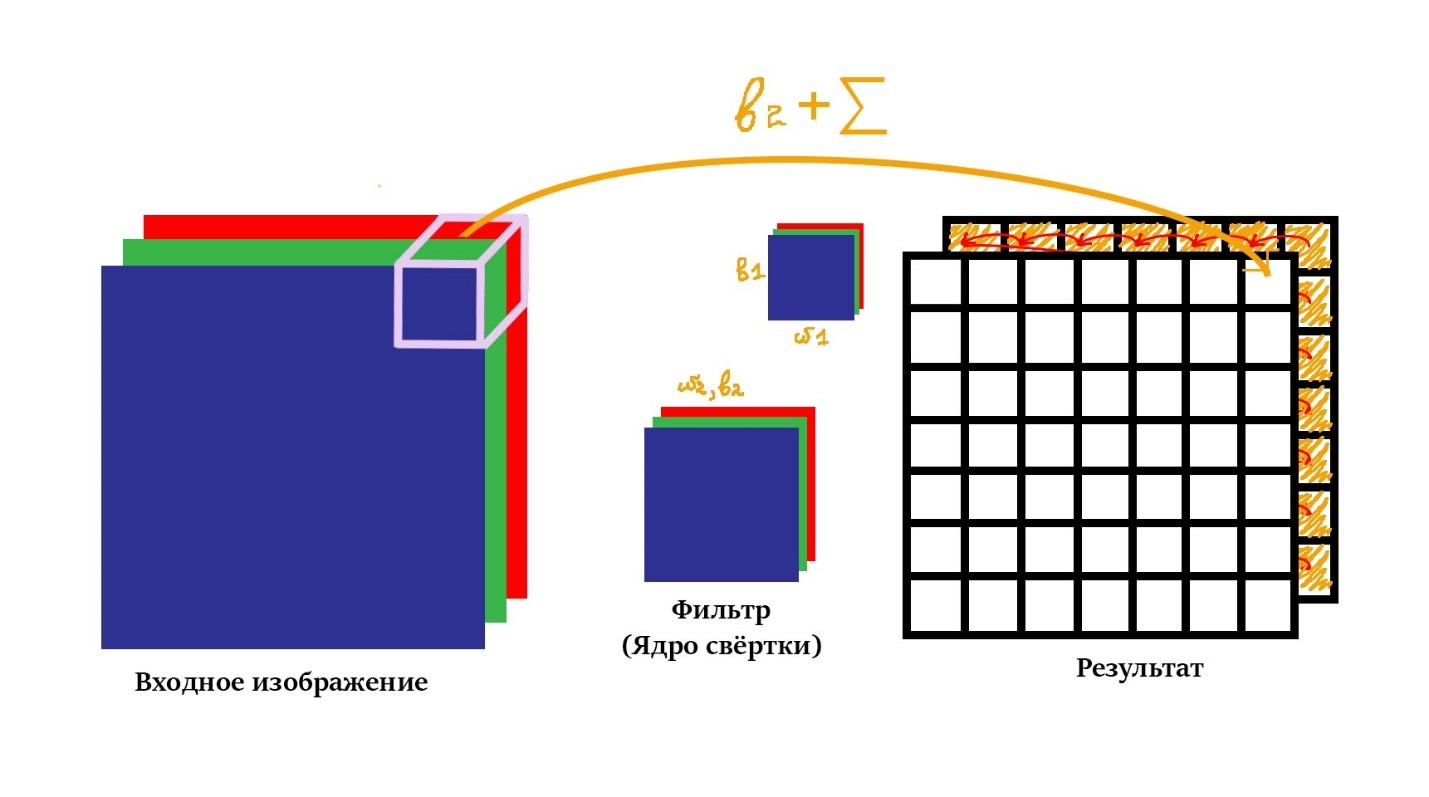

In [9]:
def set_padding2d(in_batch, padding):
    out_size = list(in_batch.shape)
    out_size[2] += 2 * padding
    out_size[3] += 2 * padding

    out_batch = torch.zeros(out_size)
    out_batch[:, :, padding:-padding, padding:-padding] = in_batch
    return out_batch

In [10]:
# Здесь мне также лень заморачиваться с перебором по циклам, да и стоит ли это того?
def set_padding2d_for_list(in_batch_list, padding):
    in_batch_np = np.array(in_batch_list)
    out_size = list(in_batch_np.shape)
    out_size[2] += 2 * padding
    out_size[3] += 2 * padding

    out_batch_np = np.zeros(out_size)
    out_batch_np[:, :, padding:-padding, padding:-padding] = in_batch_np
    return out_batch_np.tolist()

In [11]:
class Conv2dLoop_for_list(ABCConv2d):
    def __call__(self, in_batch_list, ):
        # Ну вот про это я и говорила...
        in_batch_shape = [
            len(in_batch_list),
            len(in_batch_list[0]),
            len(in_batch_list[0][0]), 
            len(in_batch_list[0][0][0])
        ]
        # тихий ужас
        print("\nIN 'Conv2dLoop_for_list' CLASS:")
        print(
            "input data type:", type(in_batch_list), "input batch:", in_batch_list,
            "input batch shape:", in_batch_shape, sep='\n', end='\n\n'
        )

        batch_size, out_channels, out_height, out_width = calc_out_shape(
            in_batch_shape,
            self.out_channels,
            self.kernel_size,
            self.stride,
            self.padding
        )

        batch_list = set_padding2d_for_list(in_batch_list, self.padding)
        print(
            "after padding:\ninput data type:", type(batch_list), "batch:", batch_list,
            "batch shape:", [
                    len(batch_list), len(batch_list[0]),
                    len(batch_list[0][0]), len(batch_list[0][0][0])
            ], sep='\n', end='\n\n'
        )

        # префикс out - выходное представление, in - исходное
        # i_out - индекс для выходного представления, i_in - для входного
        # Приходится вручную собирать выходной батч
        out_batch_list = []
        for i_image in range(batch_size):
            out_image_list = []
            # Количество многомерных ядер свертки (смотри рисунок выше)
            # определяет количество фильтров в выходном представлении
            for i_kernel in range(out_channels):
                out_image_channel_list = []
                for i_out_height in range(out_height):
                    out_line_list = []
                    for i_out_width in range(out_width):
                        # Требуется свернуть все каналы в одно значение
                        i_out_h_w_sum_val = 0
                        # Количество фильтров в каждом многомерном ядре свёрточного слоя
                        # должно совпадать с количеством каналов в сворачиваемом изображении
                        for i_channel in range(self.in_channels):
                            # Для удобства, работаем с отдельными индексами в ядре свертки и в изображении
                            for i_in_height_kernel, i_in_height_channel in zip(
                                    range(self.kernel_size),
                                    range(i_out_height * self.stride, i_out_height * self.stride + self.kernel_size)
                            ):
                                for j_in_width_kernel, j_in_width_channel in zip(
                                        range(self.kernel_size),
                                        range(i_out_width * self.stride, i_out_width * self.stride + self.kernel_size)
                                ):
                                    # Редукция по каждому фильтру свертки в многомерном ядре
                                    i_out_h_w_sum_val += self.kernel[i_kernel][i_channel][i_in_height_kernel][j_in_width_kernel] * batch_list[i_image][i_channel][i_in_height_channel][j_in_width_channel]
                        out_line_list.append(i_out_h_w_sum_val)
                    out_image_channel_list.append(out_line_list)
                out_image_list.append(out_image_channel_list)
            out_batch_list.append(out_image_list)
        if len(out_batch_list) != batch_size or \
                len(out_batch_list[0]) != out_channels or \
                len(out_batch_list[0][0]) != out_height or \
                len(out_batch_list[0][0][0]) != out_width:
            raise RuntimeError('Something went wrong!')
        return out_batch_list

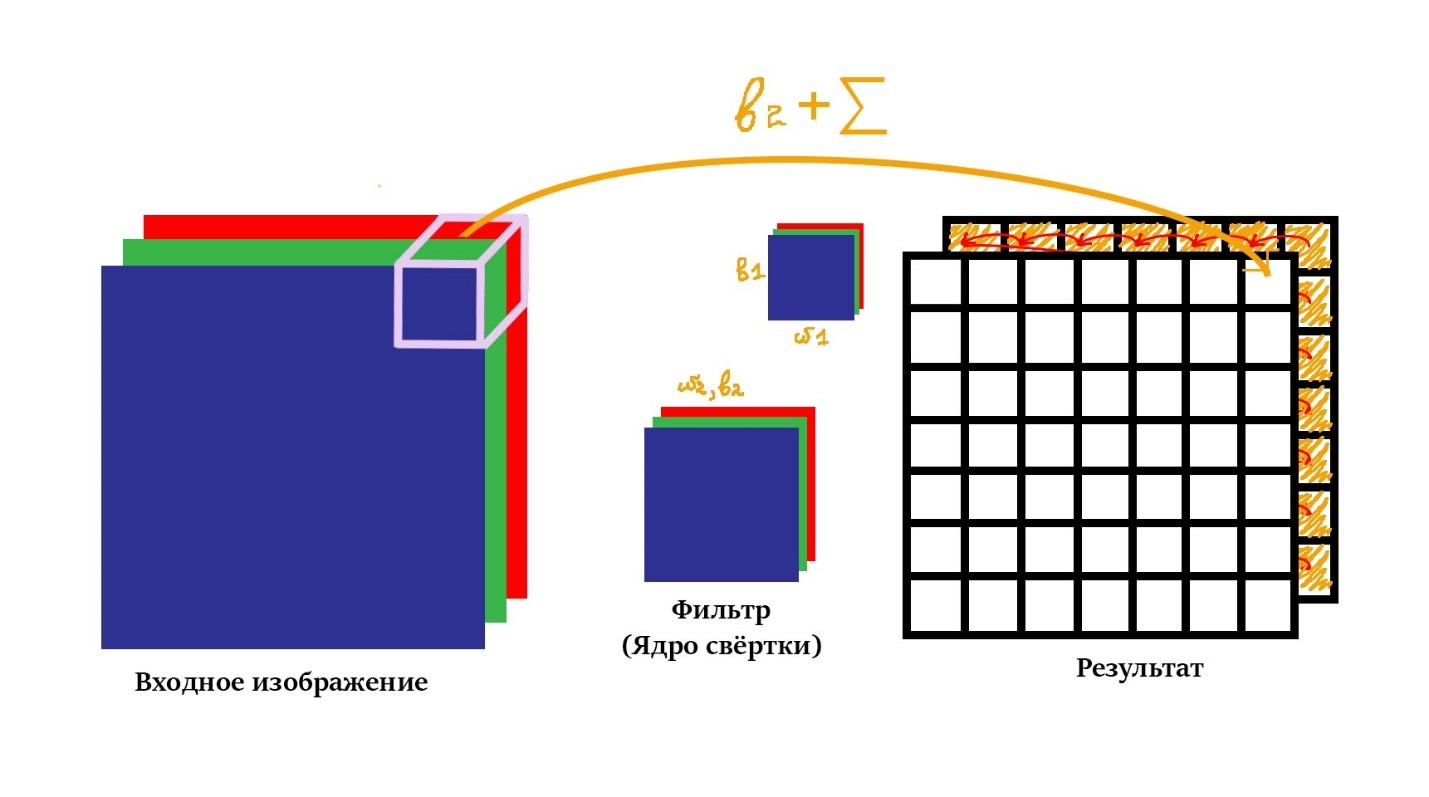

In [12]:
# Корректность реализации определится в сравнении со стандартным слоем из pytorch.
print(test_conv2d_layer_for_list(Conv2dLoop_for_list))

KERNEL:
[[[[0.0, 1.0, 0.0], [1.0, 2.0, 1.0], [0.0, 1.0, 0.0]], [[1.0, 2.0, 1.0], [0.0, 3.0, 3.0], [0.0, 1.0, 10.0]]]]
KERNEL SHAPE:
torch.Size([1, 2, 3, 3])

INPUT BATCH:
[[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]], [[9.0, 10.0, 11.0], [12.0, 13.0, 14.0], [15.0, 16.0, 17.0]]], [[[18.0, 19.0, 20.0], [21.0, 22.0, 23.0], [24.0, 25.0, 26.0]], [[27.0, 28.0, 29.0], [30.0, 31.0, 32.0], [33.0, 34.0, 35.0]]]]
INPUT BATCH SHAPE:
torch.Size([2, 2, 3, 3])


IN 'Conv2dLoop_for_list' CLASS:
input data type:
<class 'list'>
input batch:
[[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]], [[9.0, 10.0, 11.0], [12.0, 13.0, 14.0], [15.0, 16.0, 17.0]]], [[[18.0, 19.0, 20.0], [21.0, 22.0, 23.0], [24.0, 25.0, 26.0]], [[27.0, 28.0, 29.0], [30.0, 31.0, 32.0], [33.0, 34.0, 35.0]]]]
input batch shape:
[2, 2, 3, 3]

after padding:
input data type:
<class 'list'>
batch:
[[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0], [0.0, 0.0, 3.0, 4.0

In [13]:
class Conv2dLoop(ABCConv2d):
    def __call__(self, in_batch):
        batch_size, out_channels, out_height, out_width = calc_out_shape(
            in_batch.shape,
            self.out_channels,
            self.kernel_size,
            self.stride,
            self.padding
        )

        batch = set_padding2d(in_batch, self.padding)

        out_batch = torch.zeros(
            (batch_size, out_channels, out_height, out_width)
        )

        for i_image in range(batch_size):
            # Количество многомерных ядер свертки (смотри рисунок выше)
            # определяет количество фильтров в выходном представлении
            for i_kernel in range(out_channels):
                # Количество фильтров в каждом многомерном ядре свёрточного слоя
                # должно совпадать с количеством каналов в сворачиваемом изображении
                for i_channel in range(self.in_channels):
                    simple_kernel = self.kernel[i_kernel][i_channel]
                    simple_image = batch[i_image][i_channel]
                    for i_out_height in range(out_height): # Индексы для выходного представления, для входного - вычисляются
                            for i_out_width in range(out_width):
                                to_conv_image = simple_image[i_out_height * self.stride : i_out_height * self.stride + self.kernel_size, i_out_width * self.stride : i_out_width * self.stride + self.kernel_size]
                                # Требуется скалярное векторное умножение, а не матричное
                                out_batch[i_image][i_kernel][i_out_height][i_out_width] += (to_conv_image * simple_kernel).sum()
        return out_batch

In [14]:
# Корректность реализации определится в сравнении со стандартным слоем из pytorch.
print(test_conv2d_layer(Conv2dLoop))

KERNEL:
tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]]]])
KERNEL SHAPE:
torch.Size([1, 2, 3, 3])

INPUT BATCH:
tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])
INPUT BATCH SHAPE:
torch.Size([2, 2, 3, 3])

CONV ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          [468., 817.,  52.],
          [ 33., 161.,  35.]]]])
CONV ANSWER SHAPE:
torch.Size([2, 1, 3, 3])

REAL ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          

Реализация через циклы очень неэффективна по производительности. 

# Оптимизация посредством преобразования представления батча


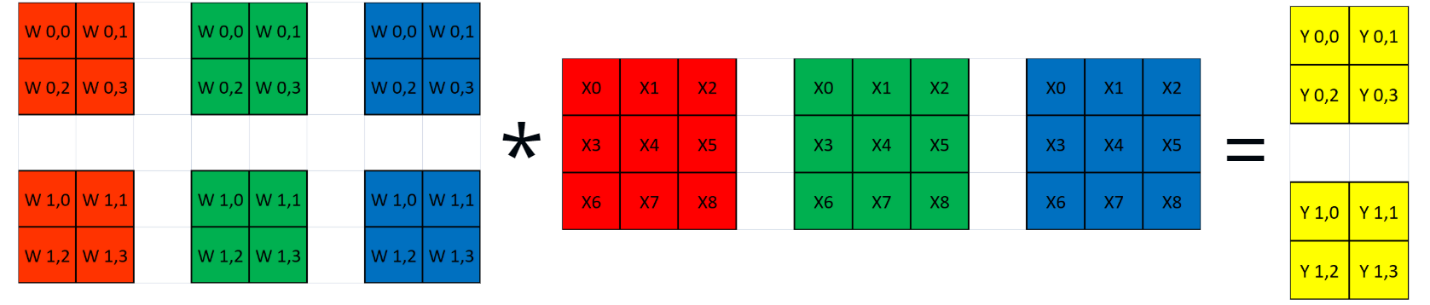

Переходим к построчному представлению фильтров и столбцовому виду сворачиваемых областей

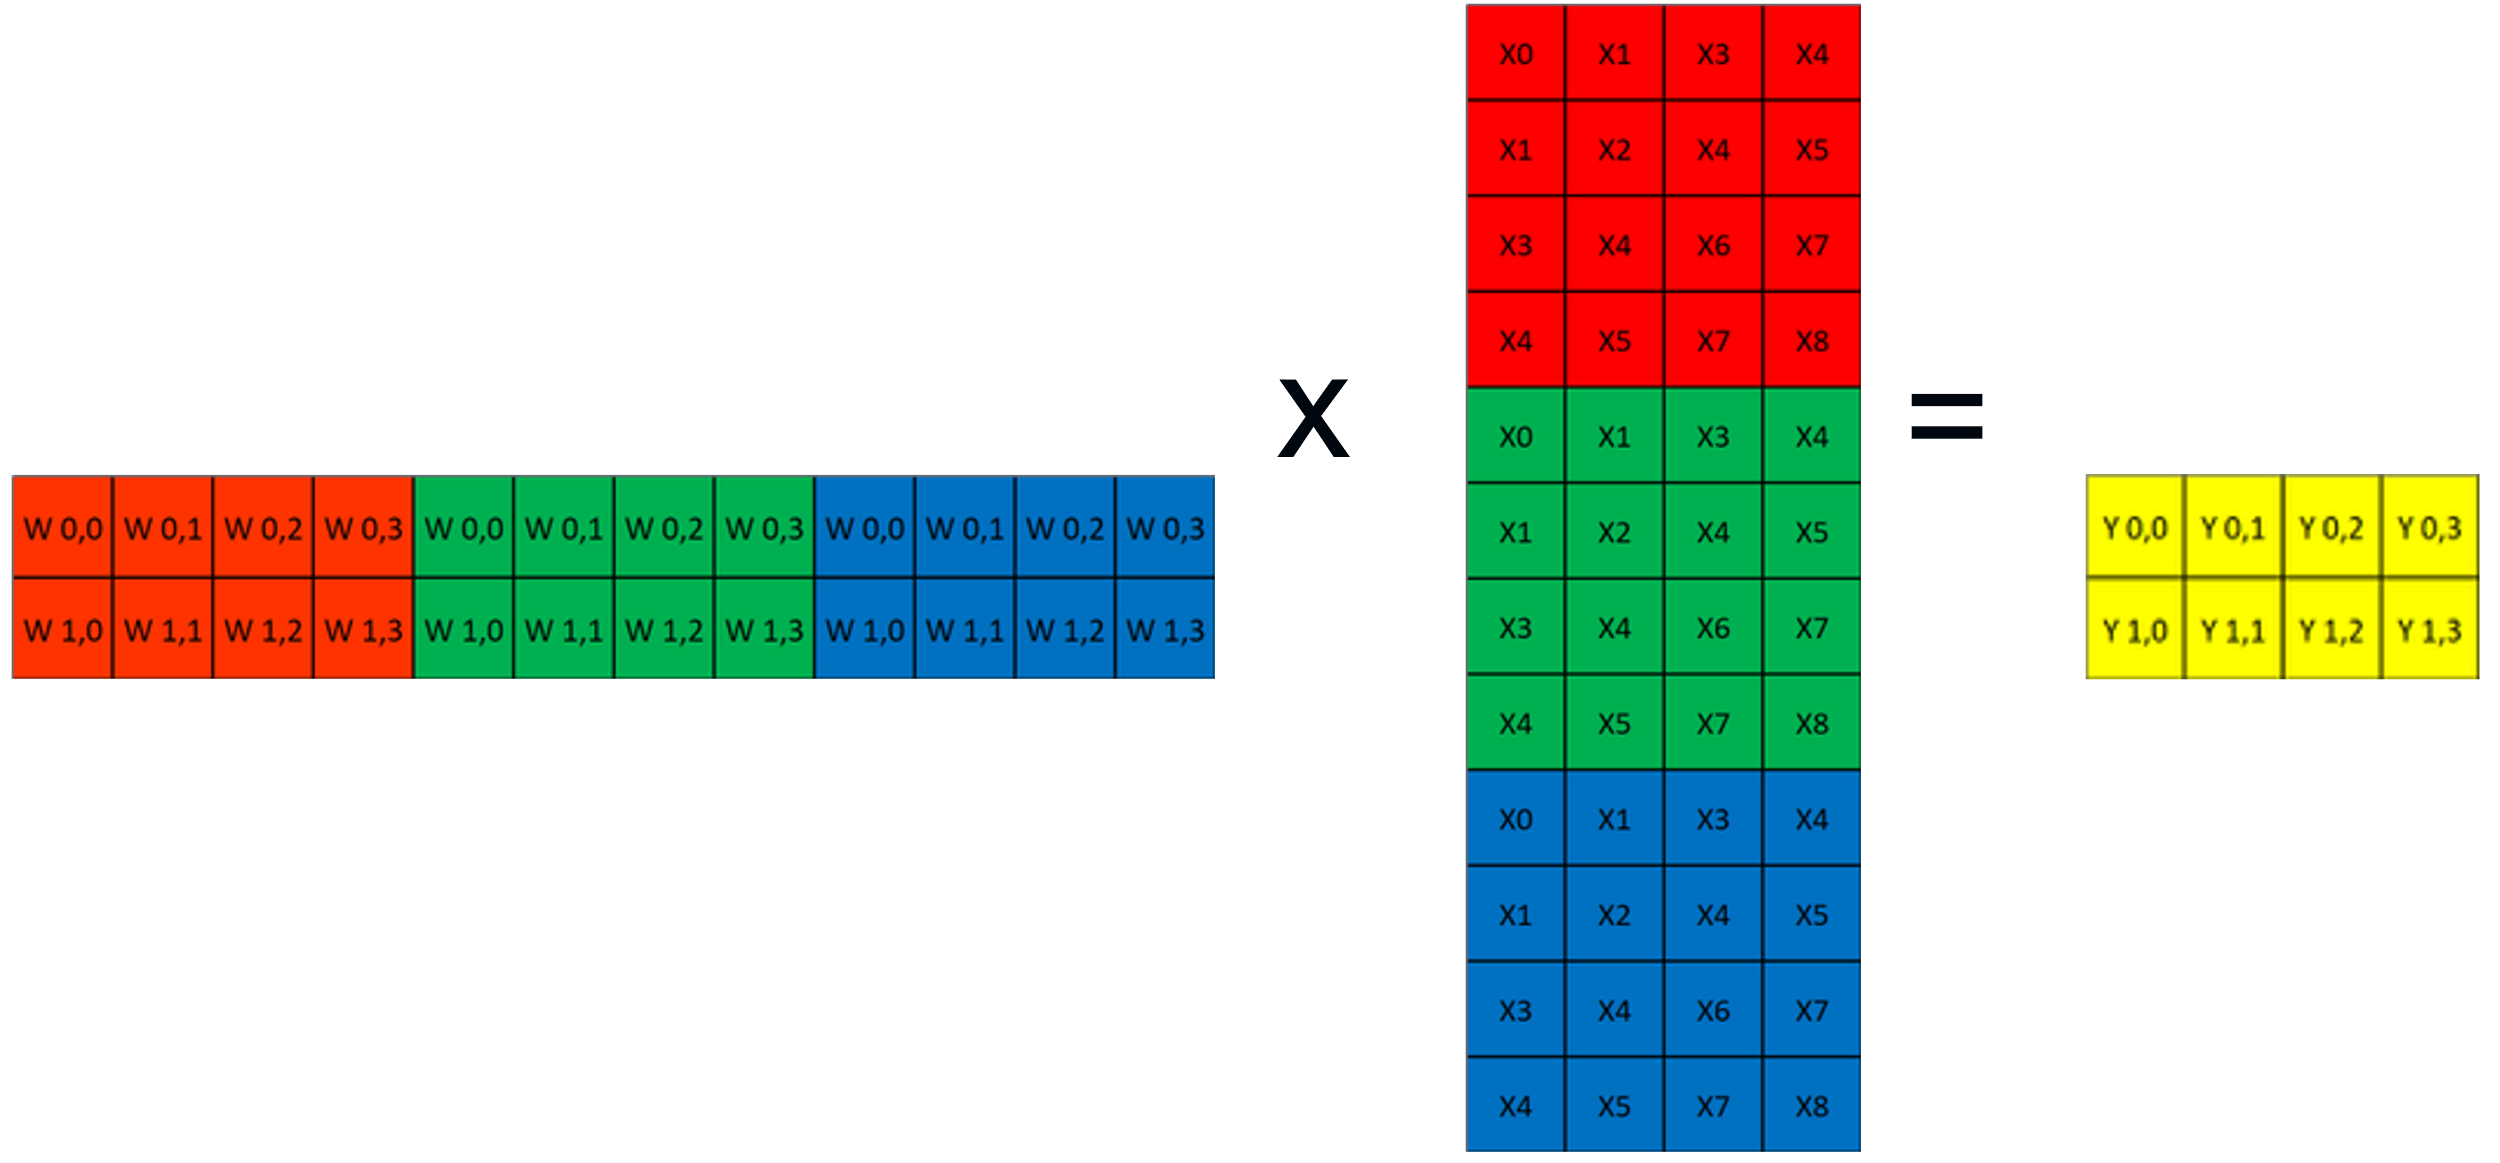

**Если изображений в батче больше одного** преобразования ядра от этого не меняется, а преобразованные матрицы входных изображений конкатенируются по горизонтали.

In [15]:
class Conv2dMatrixV2(ABCConv2d):
    # Функция преобразования кернела в нужный формат.
    def _convert_kernel(self):
        converted_kernel = self.kernel.view((self.out_channels, -1)) # Сколько многомерных фильтров, столько и строк
        return converted_kernel

    # Функция преобразования входа в нужный формат.
    def _convert_input(self, in_batch, out_height, out_width):
        out_batch = torch.zeros((self.in_channels * self.kernel_size * self.kernel_size, in_batch.shape[0] * out_height * out_width))

        # Т.К. конкатенируем картинки по горизонтали
        for i_image in range(in_batch.shape[0]):
            # Т.К. конкатенируем матрицы разных слоев картинки по вертикали
            for i_channel in range(self.in_channels):
                observed_image = out_batch[ # Просматриваем один цветной кубик нового представления одного канала изображения
                    i_channel * self.kernel_size * self.kernel_size : (i_channel + 1) * self.kernel_size * self.kernel_size,
                    i_image * out_height * out_width : (i_image + 1) * out_height * out_width,
                ]
                for i in range(out_height):
                    for j in range(out_width):
                        observed_image[:, i * out_width + j] = in_batch[
                                i_image,
                                i_channel,
                                i * self.stride : i * self.stride + self.kernel_size,
                                j * self.stride : j * self.stride + self.kernel_size
                        ].reshape(-1)
        return out_batch
        # 4 цикла лучше, чем 5

    def __call__(self, in_batch):
            batch_size, out_channels, out_height, out_width = calc_out_shape(
                in_batch.shape,
                self.kernel.shape[0],
                self.kernel.shape[2],
                self.stride,
                self.padding
            )
            batch = set_padding2d(in_batch, self.padding)

            converted_kernel = self._convert_kernel()
            converted_batch = self._convert_input(batch, out_height, out_width)
            conv2d_out_alternative_matrix_v2 = converted_kernel @ converted_batch
            return conv2d_out_alternative_matrix_v2.view(batch.shape[0], self.out_channels, out_height, out_width)

In [16]:
print(test_conv2d_layer(Conv2dMatrixV2))

KERNEL:
tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]]]])
KERNEL SHAPE:
torch.Size([1, 2, 3, 3])

INPUT BATCH:
tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])
INPUT BATCH SHAPE:
torch.Size([2, 2, 3, 3])

CONV ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          [468., 817.,  52.],
          [ 33., 161.,  35.]]]])
CONV ANSWER SHAPE:
torch.Size([2, 1, 3, 3])

REAL ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          

### Пробую уменьшить количество циклов

In [17]:
class Conv2dMatrixV2_opt(ABCConv2d):
    # Функция преобразования кернела в нужный формат.
    def _convert_kernel(self):
        converted_kernel = self.kernel.view((self.out_channels, -1)) # Сколько многомерных фильтров, столько и строк
        return converted_kernel

    # Функция преобразования входа в нужный формат.
    def _convert_input(self, in_batch, out_height, out_width):
            out_batch = torch.zeros(in_batch.shape[0], out_height * out_width, self.in_channels, self.kernel_size, self.kernel_size)

            for i in range(out_height):
                    for j in range(out_width):
                        out_batch[:, i * out_width + j, :, :, :] = \
                        in_batch[
                                :,
                                :,
                                i * self.stride : i * self.stride + self.kernel_size,
                                j * self.stride : j * self.stride + self.kernel_size
                        ]
                        # Всё тоже, что и раньше, только работаем с другим представлением данных и абстрагируемся от измерений по батчу и каналов

            out_batch = out_batch.view(in_batch.shape[0] * out_height * out_width, -1)
            out_batch.t_()

            return out_batch

    def __call__(self, in_batch):
            batch_size, out_channels, out_height, out_width = calc_out_shape(
                in_batch.shape,
                self.kernel.shape[0],
                self.kernel.shape[2],
                self.stride,
                self.padding
            )
            batch = set_padding2d(in_batch, self.padding)

            converted_kernel = self._convert_kernel()
            converted_batch = self._convert_input(batch, out_height, out_width)
            conv2d_out_alternative_matrix_v2 = converted_kernel @ converted_batch
            return conv2d_out_alternative_matrix_v2.view(batch.shape[0], self.out_channels, out_height, out_width)

In [20]:
print(test_conv2d_layer(Conv2dMatrixV2_opt))

KERNEL:
tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]]]])
KERNEL SHAPE:
torch.Size([1, 2, 3, 3])

INPUT BATCH:
tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])
INPUT BATCH SHAPE:
torch.Size([2, 2, 3, 3])

CONV ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          [468., 817.,  52.],
          [ 33., 161.,  35.]]]])
CONV ANSWER SHAPE:
torch.Size([2, 1, 3, 3])

REAL ANSWER:
tensor([[[[ 90., 121.,   0.],
          [198., 331.,  16.],
          [ 15.,  71.,  17.]]],


        [[[270., 337.,   0.],
          

ToDo - https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html#numpy.lib.stride_tricks.sliding_window_view  
Это именно тот подход, который используется в PyTorch - создание view входного тензора, тензора весов, и затем одно матричное умножение.
Да и в PyTorch можно так сделать, по идее. https://pytorch.org/docs/stable/generated/torch.as_strided.html вот эта функция используется для смены индексации по массиву. Если аккуратно всё сделать - то можно сделать то же самое, что и в sliding_window_view.

Основное отличие от циклов, задаваемых вручную - то, что создание view - очень дешевая операция, по сравнению с нарезанием тензора на части и складыванием его частей в новый тензор.